In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [4]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [5]:
decoder_disc_data = decoder_target_data[:,0,0:1]
decoder_disc_data[:,:] = 1
decoder_disc_data.shape

(4368, 1)

In [6]:
decoder_input_data_rand = None
for _ in tqdm(range(decoder_input_data.shape[0])):
    a = np.expand_dims(np.eye(decoder_input_data.shape[1], decoder_input_data.shape[2]), axis=0)
    if decoder_input_data_rand is None:
        decoder_input_data_rand = a
    else:
        decoder_input_data_rand = np.append(decoder_input_data_rand, a, axis=0)
decoder_input_data_rand.shape

  0%|          | 0/4368 [00:00<?, ?it/s]

(4368, 3822, 4)

In [7]:
decoder_disc_data_rand = decoder_input_data_rand[:,0,0:1]
decoder_disc_data_rand[:,:] = 0
decoder_disc_data_rand.shape

(4368, 1)

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3590406598946810930
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7121731584
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 17384919809839534864
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7733313536
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1354057148415975223
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 2144165316
]


2022-03-01 15:04:00.578737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 15:04:00.793094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 15:04:00.793446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 15:04:00.797597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Construct model

In [9]:
latent_dim = 256     # Latent dimensionality of the encoding space.
batch_size = 32      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 1000        # Number of epochs to train for.

In [11]:
encoder_inputs = keras.Input(shape = (None, encoder_input_data.shape[2]))

#encoder = keras.layers.Bidirectional(keras.layers.GRU(latent_dim, return_state = True))
#encoder_outputs, state_h1, state_h2 = encoder(encoder_inputs)

encoder = keras.layers.GRU(latent_dim, return_state = True)
encoder_outputs, state_h1 = encoder(encoder_inputs)

#state_h1 = keras.layers.GaussianNoise(1.0)(state_h1, training = True)
state_h1 = keras.layers.BatchNormalization(momentum = 0.6)(state_h1)

decoder_inputs = keras.Input(shape = (None, decoder_input_data.shape[2]))

decoder = keras.layers.GRU(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _ = decoder(decoder_inputs, initial_state = state_h1)
decoder_dense = keras.layers.Dense(decoder_target_data.shape[2], activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

parent_encoder = keras.layers.GRU(latent_dim, return_state = True)
parent_encoded, _ = parent_encoder(encoder_inputs)

mutation_encoder = keras.layers.GRU(latent_dim, return_state = True)
mutation_encoded, _ = mutation_encoder(decoder_outputs)

discriminator_input = keras.layers.concatenate([parent_encoded, mutation_encoded])
discriminator = keras.layers.Dense(1024, activation = "tanh")
discriminator = discriminator(discriminator_input)
disc_output = keras.layers.Dense(1, activation = "sigmoid")(discriminator)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], disc_output)

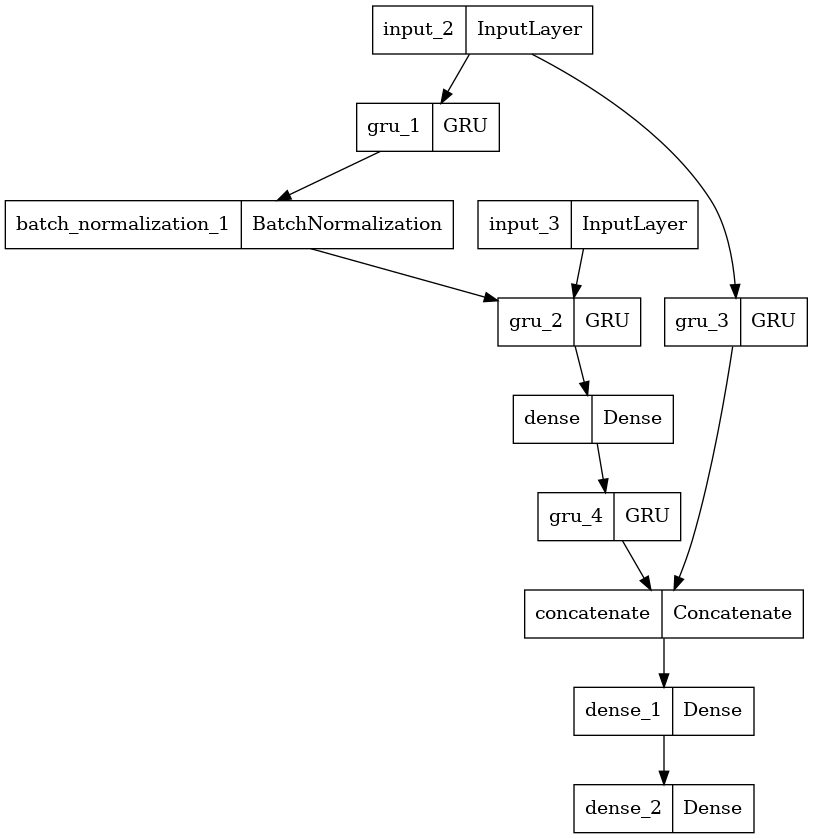

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model.png')

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 4)]    0           []                               
                                                                                                  
 gru_1 (GRU)                    [(None, 256),        201216      ['input_2[0][0]']                
                                 (None, 256)]                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, None, 4)]    0           []                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['gru_1[0][1]']              

## Train model

In [14]:
x1 = np.append(encoder_input_data, encoder_input_data, axis=0)
x2 = np.append(decoder_input_data, decoder_input_data_rand, axis=0)
y  = np.append(decoder_disc_data, decoder_disc_data_rand, axis=0)

p = np.random.permutation(len(y))
x1, x2, y = x1[p], x2[p], y[p]

In [15]:
opt = Adam(learning_rate=0.0002, beta_1=0.5)
model.compile(
    optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = patience, 
                   verbose = 1, restore_best_weights = True)

log = model.fit(
    [ x1, x2 ], y,
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    callbacks = [ es ],
    validation_split = 0.2,
)

Epoch 1/1000


2022-03-01 15:04:24.433801: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300


219/219 [==============================] - 138s 611ms/step - loss: 0.0000e+00 - accuracy: 0.5030 - val_loss: 0.0000e+00 - val_accuracy: 0.4880
Epoch 2/1000
219/219 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5030

KeyboardInterrupt: 

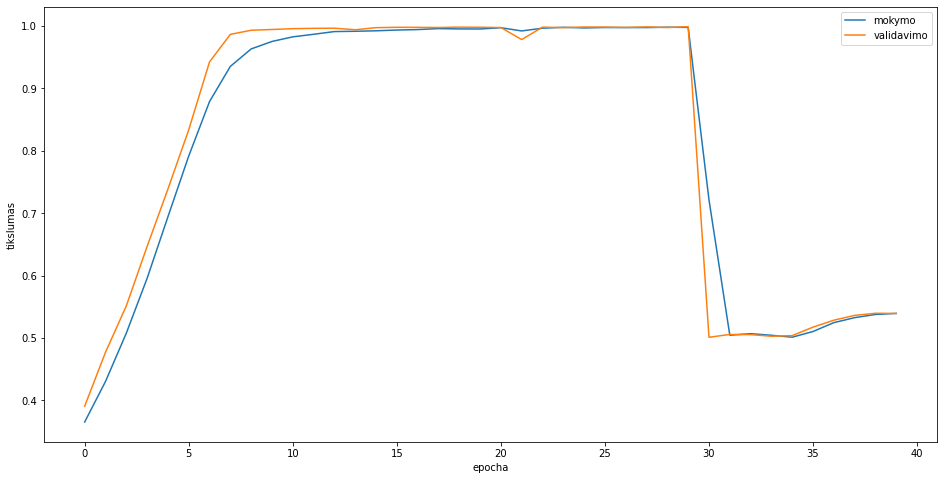

In [12]:
plt.plot(log.history['accuracy'], label = 'mokymo')
plt.plot(log.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

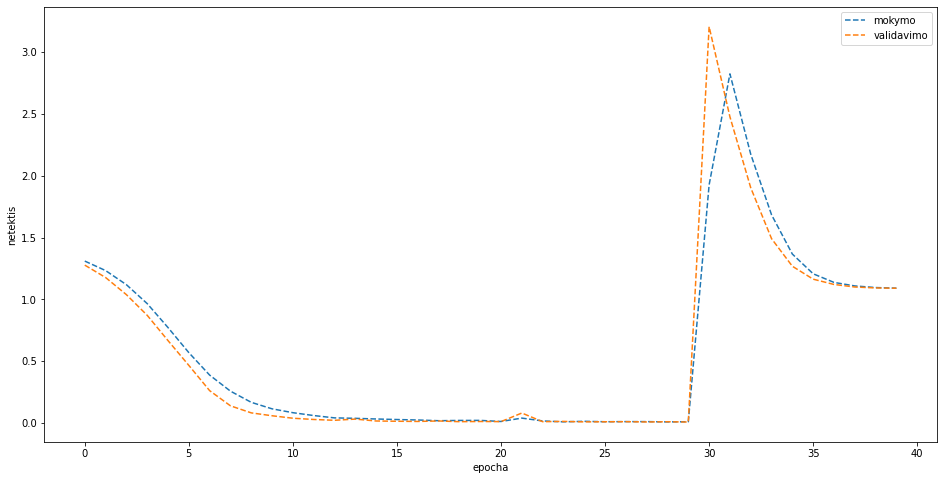

In [13]:
plt.plot(log.history['loss'], '--', label = 'mokymo')
plt.plot(log.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [14]:
model.save("data/ncbi_02/model_gru_noise_256")

2021-11-12 15:05:42.740480: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_noise_256/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_noise_256/assets
